# INET 4710 Lab6



In [1]:
# setup pyspark

import pyspark
import pyspark.sql
from pyspark.sql.functions import col, avg
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

sc = SparkContext("local", "lab6")
spark = SparkSession(sc)

## exploratory data analysys: Iris dataset


- Profile data.
- Read the iris dataset into a Pyspark data frame

In [2]:
from urllib.request import urlopen
import pandas as pd
import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
with urlopen(url) as f:
    html = f.read().decode("utf-8")

a = []
lines = html.split("\n")
for line in lines:
    x = line.split(",")
    a.append(x)

# convert to Pandas data frame
df_a = pd.DataFrame(a)
cols = ['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'species']

df_a.columns = cols
df_a = df_a.dropna()

df_a["sepalLength"].astype(np.float32)
df_a["sepalWidth"].astype(np.float32)
df_a["petalLength"].astype(np.float32)
df_a["petalWidth"].astype(np.float32)


print("Amount of data columns: %d" % df_a.shape[0])
# print(df_a.shape)
print("-"*10)
print("Each species' amount of data columns:")
print(df_a.groupby("species").count().iloc[:, 0])
print("-"*10)
print(df_a.describe())
print("-"*10)
df_a.head(5)

Amount of data columns: 150
----------
Each species' amount of data columns:
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: sepalLength, dtype: int64
----------
       sepalLength sepalWidth petalLength petalWidth          species
count          150        150         150        150              150
unique          35         23          43         22                3
top            5.0        3.0         1.5        0.2  Iris-versicolor
freq            10         26          14         28               50
----------


,sepalLength,sepalWidth,petalLength,petalWidth,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
import re
import os
from sklearn import datasets

# convert \n to lines
print(re.sub("\\n", os.linesep, datasets.load_iris().DESCR))



Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

/Users/reiven/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


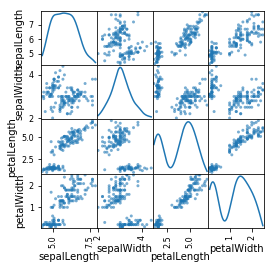

In [4]:
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

p = df_a.ix[:, "sepalLength": "petalWidth"].astype(np.float)

# fig = scatter_matrix(p)
# plt.show()

fig = scatter_matrix(p, alpha=0.6, figsize=(4,4), diagonal="kde")
plt.show()

## Part1: k-Nearest Neighbor Model

The first part of this lab is to work through the k-Nearest Neighbors model using the tutorial: "A Complete Guide to K-Nearest-Neighbors with Applications in Python and R" found at <https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter

df = df_a
X = np.array(df.ix[:, 0:4])
y = np.array(df["species"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# instantiate the kNN learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

pred = knn.predict(X_test)

acc = accuracy_score(y_test, pred) * 100
print("The accuracy of the knn classifier for k = 3 is %02f%%" % acc)

The accuracy of the knn classifier for k = 3 is 98.000000%


/Users/reiven/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Question 1
Change code in next cell to work with kNN model in previous cell.


The optimal number of neighbors is 7.


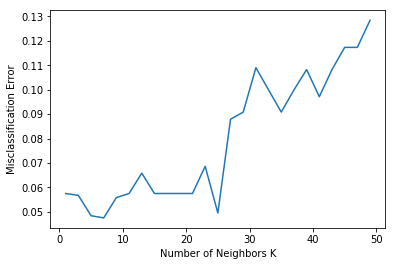

The accuracy of the optimal knn classifier for k = 7 is 98.000000%


In [6]:
# create an odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# Solution?: adding code that compute kNN which k is optimal in the range given in top of this cell) 
optimal_kNN = KNeighborsClassifier(n_neighbors=optimal_k)
optimal_kNN.fit(X_train, y_train)

pred = optimal_kNN.predict(X_test)

acc = accuracy_score(y_test, pred) * 100
print("The accuracy of the optimal knn classifier for k = 7 is %02f%%" % acc)

## Part 2: Scaling kNN - Integrating Pyspark with Scikit-learn


In [91]:
# Imports
from pyspark.mllib.linalg import Vectors
from pyspark import SparkConf, SparkContext, SparkFiles
from sklearn.neighbors import NearestNeighbors



myvecs = sc.parallelize(X_train)
myvecs.cache()

# Create knn tree locally, and broadcast
myvecscollected = myvecs.collect()
knnobject = NearestNeighbors().fit(myvecscollected)
bc_knnobj = sc.broadcast(knnobject)

# fix x shape before learning...
# I don't know why it need.
results = myvecs.map(lambda x: bc_knnobj.value.kneighbors(x.reshape(1,-1)))
y_results = np.asarray(results.collect())
print(y_results.shape)
print("Question2: show top 10 results")
print(y_results[1:10])

# accuracy score from pyspark 5 nearest neighbor calculation result.
y_train_predicted = list()

for nearest_sets in y_results:
    # print(nearest_sets.shape)
    # print(nearest_sets[1,0,])
    # print(y_train.shape)
    label_sets = list(nearest_sets[1,0,].astype(np.int32))
    label_dict = dict()
    for label in y_train[label_sets]:
        if label in label_dict.keys():
            label_dict[label] += 1
        else:
            label_dict[label] = 0
    label_predicted_current = 0
    for label in label_dict.keys():
        if label_predicted_current < label_dict[label]:
            label_predicted = label
            label_predicted_current = label_dict[label]
    y_train_predicted.append(label_predicted)

print("Question3: accuracy score:")
print(accuracy_score(y_train, y_train_predicted))
    
# change reduce, if I could.
# def reduce(y_result,**args):
#     label_sets = list(nearest_sets[1,0,].astype(np.int32))
#     label_dict = dict()
#     for label in y_train[label_sets]:
#         if label in label_dict.keys():
#             label_dict[label] += 1
#         else:
#             label_dict[label] = 0
#     label_predicted_current = 0
#     for label in label_dict.keys():
#         if label_predicted_current < label_dict[label]:
#             label_predicted = label
#             label_predicted_current = label_dict[label]
#     return label_predicted


(100, 2, 1, 5)
show top 10 results
[[[[  0.           0.26457513   0.52915026   0.54772256   0.60827625]]

  [[  1.           4.          76.          44.          86.        ]]]


 [[[  0.           0.2          0.38729833   0.42426407   0.43588989]]

  [[  2.          25.           0.          66.          16.        ]]]


 [[[  0.           0.1          0.14142136   0.14142136   0.17320508]]

  [[  3.          51.          15.           6.           7.        ]]]


 [[[  0.           0.26457513   0.60827625   0.678233     0.7       ]]

  [[  4.           1.          76.          86.          44.        ]]]


 [[[  0.           0.24494897   0.33166248   0.37416574   0.38729833]]

  [[  5.          98.          88.          14.          16.        ]]]


 [[[  0.           0.14142136   0.14142136   0.17320508   0.2236068 ]]

  [[  6.          15.           3.          51.          31.        ]]]


 [[[  0.           0.14142136   0.17320508   0.24494897   0.24494897]]

  [[  7.         

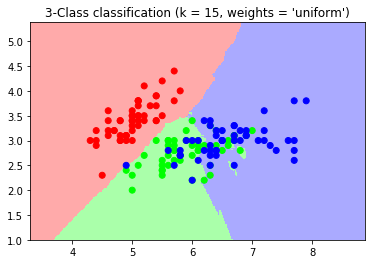

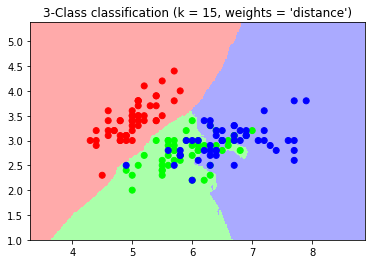

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
n_neighbors = 15
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
h=.02 #stepsizeinthemesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
plt.show()


In [96]:
import sys
sys.path.append("/Users/reiven/Documents/Python/CSCI4710/Lab6/MinHash-master")
sys.path.append("/Users/reiven/Documents/Python/CSCI4710/Lab6/MinHash-master/data")
import runMinHashExample

Shingling articles...

Shingling 100 docs took 0.04 sec.

Average shingles per doc: 247.07

Calculating Jaccard Similarities...
  (0 / 100)

Calculating all Jaccard Similarities took 0.10sec

Generating random hash functions...

Generating MinHash signatures for all documents...



Generating MinHash signatures took 0.11sec

Comparing all signatures...

Comparing MinHash signatures took 0.02sec

List of Document Pairs with J(d1,d2) more than 0.5
Values shown are the estimated Jaccard similarity and the actual
Jaccard similarity.

                   Est. J   Act. J
   t980 --> t2023   1.00     0.98
  t1088 --> t5015   1.00     0.98
  t1297 --> t4638   0.90     0.98
  t1768 --> t5248   1.00     0.98
  t1952 --> t3495   1.00     0.98
True positives:  5 / 5
False positives: 0
